# Library

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(1)

# data

In [2]:
# Hyper Parameters
EPOCH = 1               
BATCH_SIZE = 50
LR = 0.001              
DOWNLOAD_MNIST = False

In [3]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='D:/mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


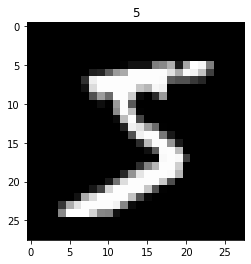

In [4]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [5]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='D:/mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]

C:\Users\user\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\user\AppData\Roaming\Python\Python38\site-packages\torchvision\datasets\mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# Function

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [8]:
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [9]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   

In [10]:
lost_list =[]

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        lost_list.append(loss.item())
        
        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = sum(pred_y == test_y) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| test accuracy: %.2f' % accuracy)
           
    print('done') 


# plt.ioff()

Epoch:  0 | train loss: 2.3125 | test accuracy: 0.18
Epoch:  0 | train loss: 0.4850 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3738 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3810 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2345 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1631 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0555 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1947 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0674 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0985 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0847 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0597 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0408 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0896 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0192 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0906 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2287 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0407 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0432 | test accuracy

In [11]:
for i, l_his in enumerate(lost_list):
    print([i,l_his])

[0, 2.312490701675415]
[1, 2.290438652038574]
[2, 2.25449275970459]
[3, 2.2511489391326904]
[4, 2.20986270904541]
[5, 2.2341904640197754]
[6, 2.0951719284057617]
[7, 2.212785005569458]
[8, 2.170302152633667]
[9, 2.0583860874176025]
[10, 1.9927449226379395]
[11, 2.0499045848846436]
[12, 1.9231882095336914]
[13, 1.8792458772659302]
[14, 1.830405592918396]
[15, 1.7506991624832153]
[16, 1.8600884675979614]
[17, 1.5614694356918335]
[18, 1.5314358472824097]
[19, 1.3992292881011963]
[20, 1.37058424949646]
[21, 1.2943099737167358]
[22, 1.194191336631775]
[23, 1.2392042875289917]
[24, 1.0613353252410889]
[25, 1.0483471155166626]
[26, 0.7914177179336548]
[27, 0.8549042344093323]
[28, 0.7558843493461609]
[29, 0.7543759346008301]
[30, 0.855858325958252]
[31, 0.5318251252174377]
[32, 0.6963332891464233]
[33, 0.565680205821991]
[34, 1.1257274150848389]
[35, 0.6650322675704956]
[36, 0.7777002453804016]
[37, 0.6858054399490356]
[38, 0.5594832897186279]
[39, 0.5487794280052185]
[40, 0.8207573890686035]

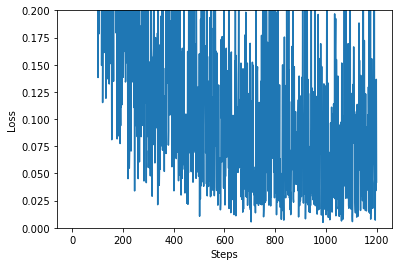

In [12]:
# for i, l_his in enumerate(lost_list):


#     plt.plot(lost_list)

plt.plot(lost_list)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()